# Feature Search

It's become clear that our features are not good for this problem. This notebook will help us find better ones.

Strategy:

1. Generate the good trajectory of length ~616;
2. Fit it with the OLS solution with different samplers (e.g. u5);
    1. See how the pivots are fit
    2. See how well we fit the rest of the examples

We can try different regularization settings as well.

In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
import gymnasium as gym

import adaptive_time.utils
import adaptive_time.features

from adaptive_time import run_lib
from adaptive_time import samplers
from adaptive_time import environments
from adaptive_time import mc2

from pprint import pprint

In [3]:
adaptive_time.utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [4]:
regenerate_trajectory = True
# regenerate_trajectory = False


## Generate the trajectory

In [5]:
policy_to_evaluate = "policy_to_eval_good.npy"


In [6]:
if regenerate_trajectory:

    run_lib.register_gym_envs()
    env = gym.make('CartPole-OURS-v0')

    # Just a specified sequence of actions.
    policy_to_use = run_lib.ActionIterator(np.load(
        adaptive_time.utils.get_abs_path(policy_to_evaluate)))

    trajectory, early_term = environments.generate_trajectory(
            env, policy=policy_to_use,
            # env, policy=lambda s: policy(state=s, weights=weights),
            termination_prob=0.0, max_steps=None)
    
    assert not early_term
    print("Tracjectory length:", len(trajectory))
    print("total (undiscounted) return:", sum(ts[2] for ts in trajectory))

    print()
    # Find stats about the states in the trajectory.
    # Also find bounding boxes for the states


Tracjectory length: 616
total (undiscounted) return: 611.4690563799434



## Setup the features and regularizer

In [7]:
def make_features(order):
    phi = adaptive_time.features.Fourier_Features()
    phi.init_fourier_features(4, order)
    x_thres = 2.4
    theta_thres = 0.418
    phi.init_state_normalizers(
        np.array([x_thres,2.0,theta_thres,1]),
        np.array([-x_thres,-2.0,-theta_thres,-1]))
    return phi

phi = make_features(4)


### Observe the features

In [8]:
phi.order_list

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       ...,
       [4, 4, 4, 2],
       [4, 4, 4, 3],
       [4, 4, 4, 4]])

In [9]:
phi.num_parameters

625

In [10]:
import math
12 * 2 * math.pi / 360

0.20943951023931953

## Process the trajectory

In [11]:

def ols_monte_carlo(
        trajectory, sampler: samplers.Sampler2,
        phi, do_weighing, gamma, regularizer):
    """Processes a trajectory to find the weights using OLS Monte Carlo."""

    N = len(trajectory)
    pivots = sampler.pivots(trajectory)
    print(f"Using {len(pivots)}/{N} samples.")
    print(f"  regularizer={regularizer}.")

    feature_len = 2*phi.num_parameters

    # Could optimize the below by iterating only over pivots,
    # and using the discounted returns from `all_returns` directly.
    all_returns = adaptive_time.utils.discounted_returns(trajectory, gamma)
    all_features = np.zeros((N, feature_len))

    pivot_idx = -1  # Start with the last one, count down.
    prev_pivot = N-1
    G = 0

    # 2 is the number of actions.
    x_sa = np.zeros((2, phi.num_parameters))
    features_dt = np.zeros((feature_len, feature_len))
    targets_dt = np.zeros(feature_len)
    all_dts = []

    for t in range(N-1,-1,-1):
        state, action, reward, _ = trajectory[t]
        G = gamma * G + reward

        if G != all_returns[t]:
            print(f"Error in G: {G} != {all_returns[t]}")
            assert False
        x = phi.get_fourier_feature(state)
        x_sa = mc2.phi_sa(x, action, x_sa)
        x_sa_flat = x_sa.flatten()
        all_features[t] = x_sa_flat

        if t in pivots:
        # Process the pivot.
            # all_pivot_features[pivot_idx] = x_sa_flat

            if t == N-1:
                dt = 1   # The weight for the last update.
            else:
                dt = prev_pivot - t
                prev_pivot = t
            if not do_weighing:
                dt = 1
            all_dts.append(dt)

            # the scale is increasing over time, so we need to scale the features
            features_dt = (
                features_dt + dt * np.outer(x_sa_flat, x_sa_flat) / len(pivots))
            targets_dt = targets_dt + dt * G * x_sa_flat / len(pivots)
            # features_dt = features_dt + dt * np.outer(x_sa_flat, x_sa_flat)
            # targets_dt = targets_dt + dt * G * x_sa_flat
            pivot_idx -= 1

    features_dt = features_dt + regularizer * np.eye(features_dt.shape[0])

    features = features_dt.copy()
    targets = targets_dt.copy()
    # features = features + features_dt
    # targets = targets + targets_dt/_TARGET_SCALAR

    # print("dt's used: ", all_dts)

    try:
        # weights = np.linalg.solve(features, targets)
        (weights, _, rank, _) = np.linalg.lstsq(
            features,
            targets
        )
        # print(np.min(x_sa_flat), np.max(x_sa_flat))
        # # print(x_sa_flat.shape, features.shape, targets.shape)
        # # print(weights.shape)
        print("rank:", rank)
        # print("feat: {} targ: {}".format(
        #     np.linalg.norm(features/scale, ord=1), np.linalg.norm(targets/scale, ord=1)))
        print("param: {}".format(np.linalg.norm(weights)))
        print("residual: {}".format(np.linalg.norm(
                features @ weights - targets), ord=1))

    except np.linalg.LinAlgError:
        print("Singular matrix in OLS. Using previous weights.")

    return (
        weights,
        (targets, features),
        (np.array(all_returns), all_features, pivots)
    )


def get_errors(returns, features, weights):
    """Check the fit of the predicted features to the returns."""
    return np.abs(features @ weights - returns)


In [21]:

def learn(trajectory, my_samplers, phi, gamma, regularizer):
    all_weights = {}
    all_pivots = {}
    all_all_features = {}
    all_all_returns = {}
    for variant, sampler in my_samplers.items():
        print()
        print("-------- Sampler: ", variant)

        weights, _, (returns, features, pivots) = ols_monte_carlo(
            trajectory, sampler, phi, True, gamma, regularizer)
        
        all_all_returns[variant] = returns
        all_all_features[variant] = features
        all_pivots[variant] = pivots
        all_weights[variant] = weights

        pivot_error = get_errors(returns[pivots], features[pivots], weights)
        all_errors = get_errors(returns, features, weights)

        print("Error in predictions (mean, max) -- pivots:",
            np.mean(pivot_error), np.max(pivot_error))
        print("Error in predictions (mean, max) -- all:",
            np.mean(all_errors), np.max(all_errors))

        print()
        print("Extra details")
        print("Return in the start state:", returns[0])
    return all_weights, all_all_features, all_all_returns, all_pivots

In [ ]:

def make_plots(all_weights, all_all_features, all_all_returns, all_pivots, force_ylims):

    for variant in all_weights.keys():

        # num_rows = (num_episodes+1) // 2
        # fig, ax = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows + 1),
        #                        sharex=True, sharey=False)
        # axes = ax.flatten()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # Find predictions on all and the pivots.
        feats = all_all_features[variant]
        w = all_weights[variant]
        ps = all_pivots[variant]
        rets = all_all_returns[variant]

        pred_rets_pivots = feats[ps] @ w
        pred_rets_all = feats @ w

        # action = 0
        # pred_rets = pred_rets[np.where(acts_good == action)]
        # true_rets = true_rets[np.where(acts_good == action)]

        # First plot them everywhere.
        axes[0].plot(pred_rets_all, label="Pred", linestyle="", marker=".")
        axes[0].plot(rets, label="True", linestyle="-")
        axes[0].set_title(f"Predictions on all states")
        
        # Plot only on the pivots.
        axes[1].plot(ps, pred_rets_pivots, linestyle="", marker=".")
        axes[1].plot(ps, rets[ps], linestyle="-")
        axes[1].set_title(f"Predictions on pivots")

        if force_ylims:
            axes[0].set_ylim(-30, 630)
            axes[1].set_ylim(-30, 630)

        fig.legend()
        fig.suptitle(f"{variant}; Pred vs True Returns")
        plt.show()


### No regularization

In [13]:
my_samplers = dict(
    u1=samplers.UniformSampler2(1),
    u5=samplers.UniformSampler2(5),
    u20=samplers.UniformSampler2(20),
)

phi = make_features(4)
regularizer = 0.0

all_weights, all_all_features, all_all_returns, all_pivots = learn(
    trajectory, my_samplers, phi, gamma=0.99999, regularizer=regularizer)



-------- Sampler:  u1
Using 616/616 samples.
  regularizer=0.0.


/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_41030/2868353829.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (weights, _, rank, _) = np.linalg.lstsq(


rank: 248
param: 4706236.460938105
residual: 3.6232499789926523e-07
Error in predictions (mean, max) -- pivots: 1.033666608274189 6.701330736801161
Error in predictions (mean, max) -- all: 1.033666608274189 6.701330736801161

Extra details
Return in the start state: 609.5992462873995

-------- Sampler:  u5
Using 124/616 samples.
  regularizer=0.0.
rank: 119
param: 3135288.592363637
residual: 1.3272074367222689e-06
Error in predictions (mean, max) -- pivots: 0.2589105680918419 2.7467300656601594
Error in predictions (mean, max) -- all: 14348.046584071573 1394208.9709978688

Extra details
Return in the start state: 609.5992462873995

-------- Sampler:  u20
Using 31/616 samples.
  regularizer=0.0.
rank: 55
param: 26764.202782420794
residual: 1.5744866888470758e-09
Error in predictions (mean, max) -- pivots: 4.651311611139003e-08 4.4879428173771885e-07
Error in predictions (mean, max) -- all: 1939.2651743870538 17473.454358923984

Extra details
Return in the start state: 609.5992462873995


In [14]:
all_all_returns["u1"][0]

609.5992462873995

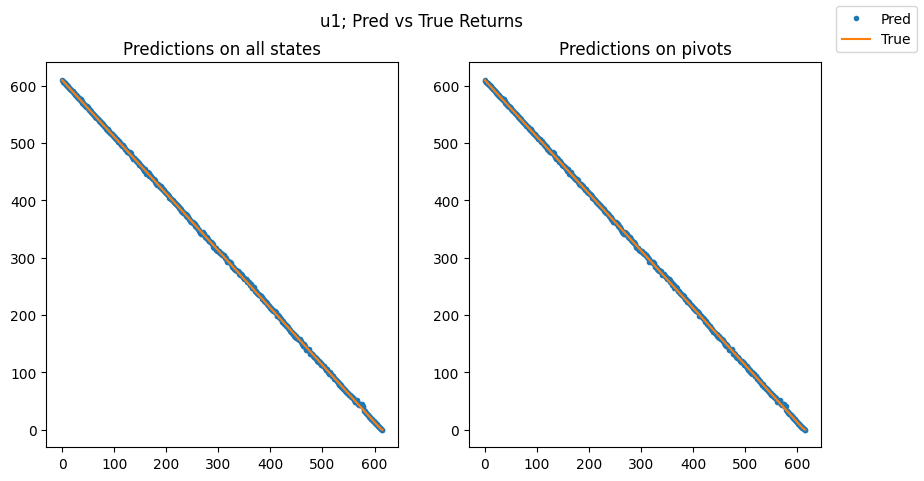

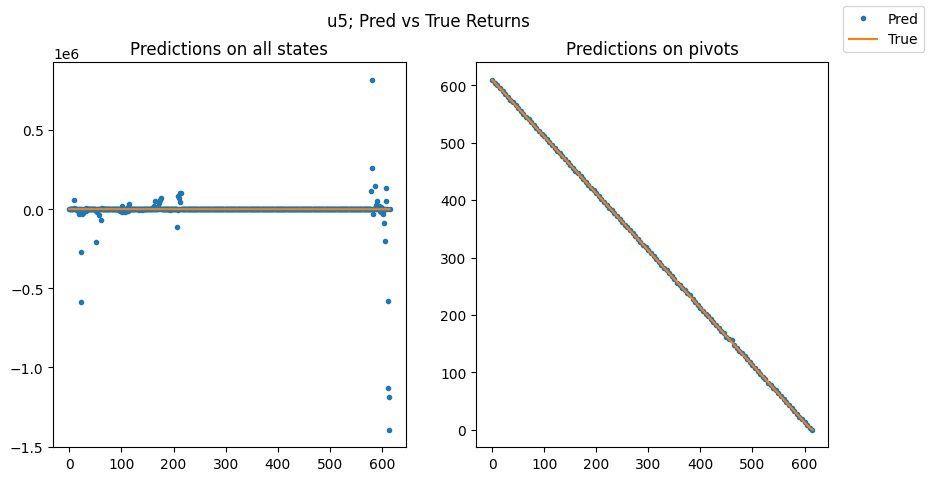

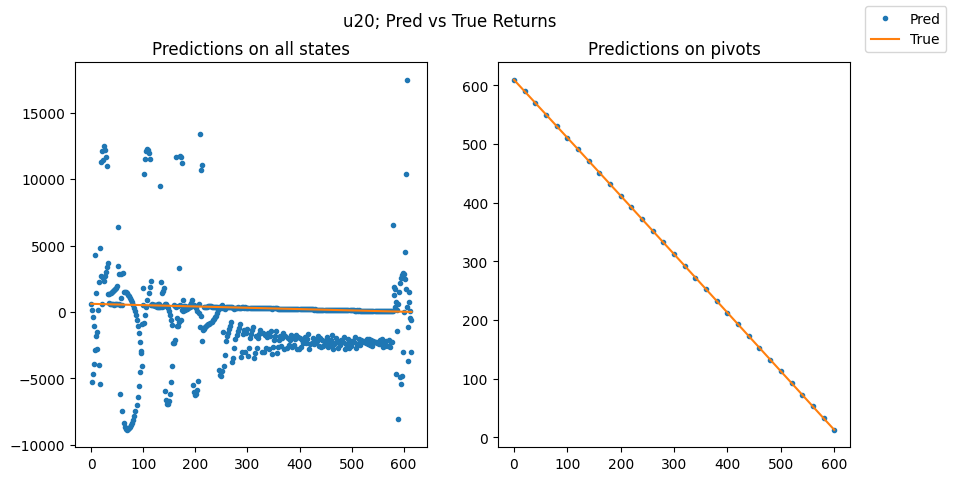

In [16]:

make_plots(all_weights, all_all_features, all_all_returns, all_pivots,
           force_ylims=False)
        #    force_ylims=True)


### Some regularization

In [28]:
my_samplers = dict(
    u1=samplers.UniformSampler2(1),
    u5=samplers.UniformSampler2(5),
    u20=samplers.UniformSampler2(20),
)

phi = make_features(4)
regularizer = 0.05

all_weights, all_all_features, all_all_returns, all_pivots = learn(
    trajectory, my_samplers, phi, gamma=0.99999, regularizer=regularizer)



-------- Sampler:  u1
Using 616/616 samples.
  regularizer=0.05.


/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_41030/2868353829.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (weights, _, rank, _) = np.linalg.lstsq(


rank: 1250
param: 161.79384205905762
residual: 5.436141638288095e-12
Error in predictions (mean, max) -- pivots: 41.13694729670136 174.00945704052393
Error in predictions (mean, max) -- all: 41.13694729670136 174.00945704052393

Extra details
Return in the start state: 609.5992462873995

-------- Sampler:  u5
Using 124/616 samples.
  regularizer=0.05.
rank: 1250
param: 239.81621920147043
residual: 3.745031767239581e-11
Error in predictions (mean, max) -- pivots: 31.79645885828284 88.72341061494299
Error in predictions (mean, max) -- all: 38.64635473937224 306.00753804829174

Extra details
Return in the start state: 609.5992462873995

-------- Sampler:  u20
Using 31/616 samples.
  regularizer=0.05.
rank: 1250
param: 341.6305089893192
residual: 2.442592309983394e-10
Error in predictions (mean, max) -- pivots: 13.757381752651188 54.77126604596252
Error in predictions (mean, max) -- all: 106.02742441081344 1154.2668836885807

Extra details
Return in the start state: 609.5992462873995


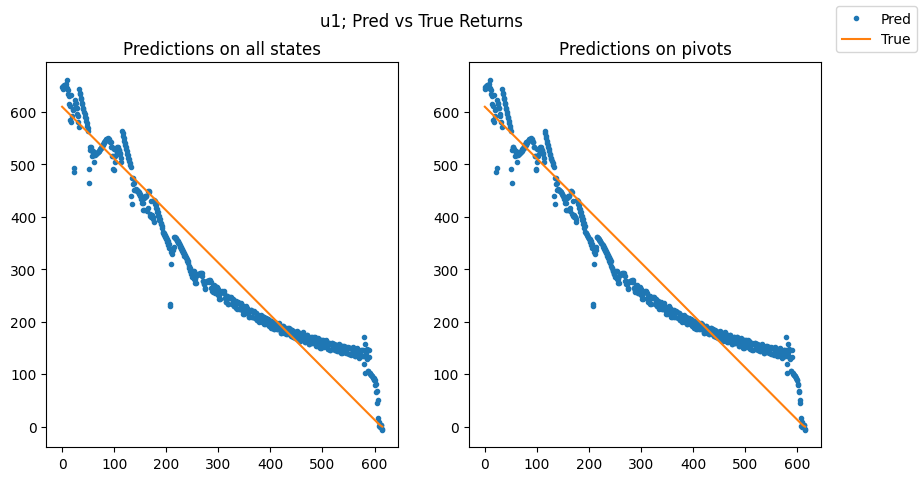

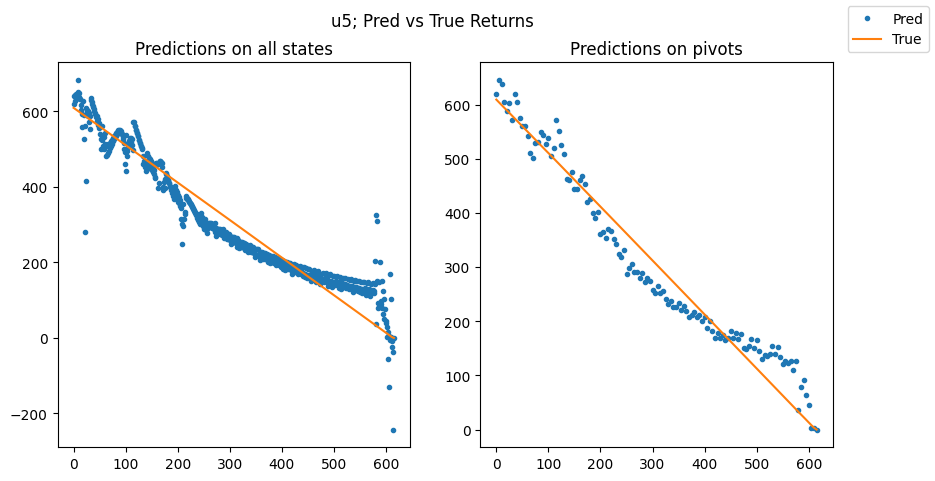

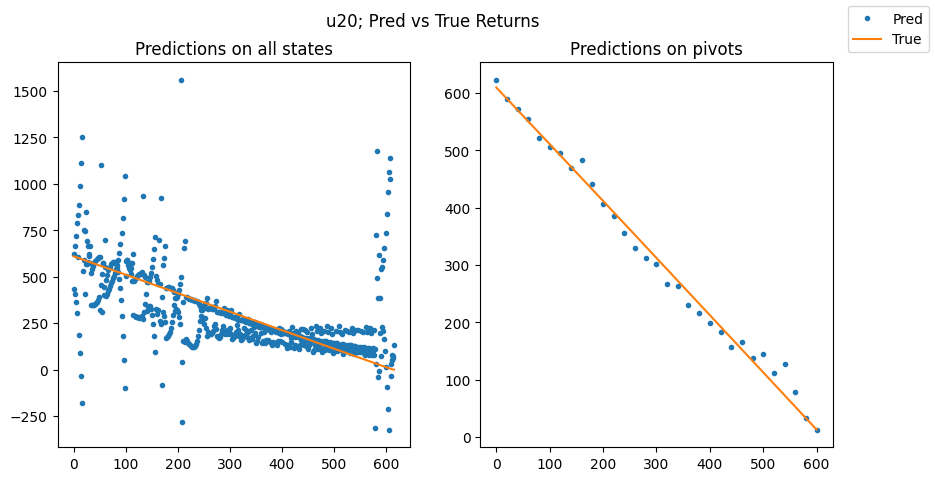

In [29]:

make_plots(all_weights, all_all_features, all_all_returns, all_pivots,
           force_ylims=False)
        #    force_ylims=True)
